In [21]:
%pylab inline
import xarray as xr
from matplotlib import cm

Populating the interactive namespace from numpy and matplotlib


# Equatorial waves in TPACE-Isca
Here begins an exploration of equatorial waves in TPACE experiment using Isca (McKinney and Mitchell 2022).  Our goal is to determine the influence of TPACE parameters on said waves, and relate their behavior to that of ageostrophic instability, convectively coupled waves, and the MJO.  
A comparison with reanalysis and/or RCP8.5 will be done in collaboration with Charles Jones.

**21Jan22** Meeting with Charles & Leila
Discussion:
1. Overview of TPACE experiment and plan for analyzing equatorial waves
2. Formate hypotheses based on theories and observations of MJO and convectively coupled waves
3. Charles will provide EOF and compositing calcs, and point to MJOMIP diagnostics
4. 

## Task 1:  Spectral analysis
Our first task is to develop spectra (and Hovmollers) of equatorial waves, and analyze them in the context of equatorial wave dispersion relations.  For this, we will borrow from MV10, MVP14 and ongoing work with Tersi (Mitchell & Ar}ias 2022).  

Consider exploring spectra of the following:
1. Surface winds
2. Precipitation
3. [Surface pressure]

### Aquaplanet with aseasonal forcing
TPACE-Isca aquaplanet experiments are our starting point.  McKinney & Mitchell (2022) performed simulations over ## years, and our analysis is daily data over the last year.
Let's first look at the Hovmoller of precipitation, averaged from 15S:15N.

In [493]:
#dat = xr.open_dataset('/data1/mmckinney/isca/habitability_project/aquaplanet_data/fan_aqua_beta_1/run0025/atmos_yearly.nc')
#dat = xr.open_dataset('/data1/mmckinney/isca/habitability_project/fandry_es0_2/run0040/atmos_yearly.nc')
dat = xr.open_dataset('/data1/mmckinney/isca/habitability_project/fandry_qdef_higheq_lat_5/run0025/atmos_yearly.nc')




In [494]:
lat = dat['lat']
lon = dat['lon']
p = dat['pfull']
nk = len(p)
nj = len(lat)
ni = len(lon)
time = dat['time']
nl = len(time)
ti,tf = 0,nl+1
j15S = argmin(abs(lat+15.)).values
j15N = argmin(abs(lat-15.)).values+1
rain = dat['precipitation'][ti:tf,j15S:j15N].mean(dim='lat')*86400./1000.
u = dat['ucomp'][ti:tf,:,j15S:j15N].mean(dim='lat')
v = dat['vcomp'][ti:tf,:,j15S:j15N].mean(dim='lat')

Text(0,0.5,u'DOY')

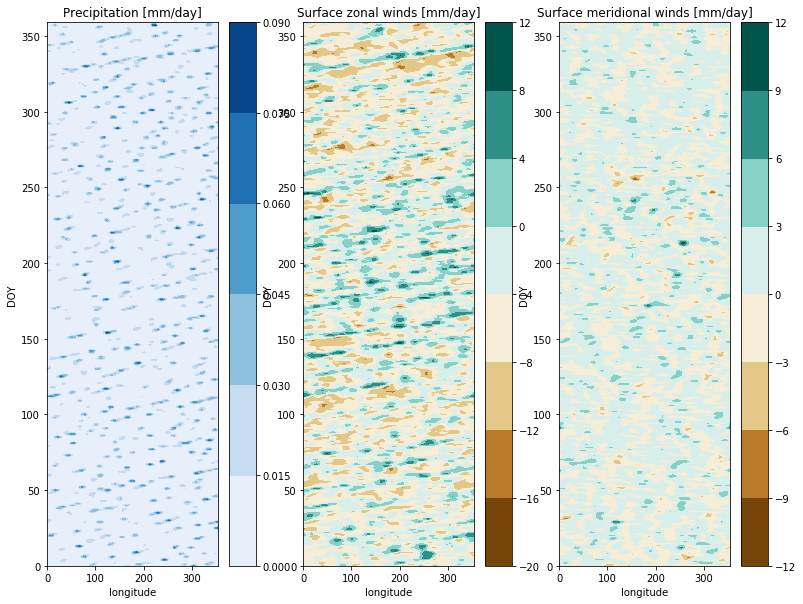

In [495]:
figsize(13,10)
subplot(131)
contourf(lon,arange(360),rain,cmap=cm.Blues)
colorbar()
title('Precipitation [mm/day]')
xlabel('longitude')
ylabel('DOY')
subplot(132)
contourf(lon,arange(360),u[:,-1],cmap=cm.BrBG)
colorbar()
title('Surface zonal winds [mm/day]')
xlabel('longitude')
ylabel('DOY')
subplot(133)
contourf(lon,arange(360),v[:,-1],cmap=cm.BrBG)
colorbar()
title('Surface meridional winds [mm/day]')
xlabel('longitude')
ylabel('DOY')

There are very clearly propagating, coherent signals.  It would appear they are all moving eastward, circumnavigating in roughly 50 days.  

In [496]:
circumference = 2.*pi*6400.e3
period = 50.*86400.
speed = circumference/period
print 'Eastward waves are moving ~%i m/s' %speed

Eastward waves are moving ~9 m/s


Now for the spectrum.  This is simply the 2D-FFT of the above Hovmoller...

In [497]:
# Compute power spectrum
## DEFS
# nt = total index length of selected data
# win = index length of FFT window
# lmax = number of windows in selected data
a    = 6378.e3
lev = '1000'
km = argmin(abs(p-float(lev)))
uave1 = average(u[:,km],axis=-1)
vave1 = average(v[:,km],axis=-1)
utave = average(u[:,km],axis=0)
rain1 = average(rain,axis=-1)
u_zonasym = u[:,km] - uave1[:,None]  # zonal anomalies
v_zonasym = v[:,km] - vave1[:,None]  # zonal anomalies
u_trans = u[:,km] - utave[None,:]  # transients
rain_zonasym = rain - rain1[:,None]  # zonal anomalies
y = a*lat*pi/180.
#win = 4*50  # 50 days
win = nl    # entire range  
lmax = nl/win

dt = 86400.

# fft
nfreq= win
n    = fftfreq(ni,d=1./ni)
freq = fftfreq(nfreq,d=dt)
ufft1 = zeros((lmax,win,ni),'d')
vfft1 = zeros((lmax,win,ni),'d')
prfft1 = zeros((lmax,win,ni),'d')
upr_upr = zeros((lmax,win,ni),'d')
prpr_prpr = zeros((lmax,win,ni),'d')
uave_sm = zeros((lmax),'d')
uave_nosm = zeros((lmax),'d')
for l in range(lmax):
    ufft = fft2(u_zonasym[l*win:(l+1)*win],axes=(0,-1))
    ufft1[l] = ufft
    vfft = fft2(v_zonasym[l*win:(l+1)*win],axes=(0,-1))
    vfft1[l] = vfft
    prfft = fft2(rain_zonasym[l*win:(l+1)*win],axes=(0,-1))
    prfft1[l] = prfft
    uave_sm[l] = average(uave1[l*win:(l+1)*win],axis=0)
    # power spectra
    upr_upr[l] = 2.*real(ufft*conj(ufft))+2.*real(vfft*conj(vfft))
    prpr_prpr[l] = 2.*real(prfft*conj(prfft))

nunsort = n.copy()
funsort = freq.copy()
nsort = argsort(n)
fsort = argsort(freq)
n = n[nsort]
freq = freq[fsort]
# Sort for plotting purposes
for l in range(lmax):
    for ll in range(nfreq):
        upr_upr[l,ll,:] = upr_upr[l,ll,nsort]
        prpr_prpr[l,ll,:] = prpr_prpr[l,ll,nsort]
    for i in range(len(n)):
        upr_upr[l,:,i] = upr_upr[l,fsort,i]
        prpr_prpr[l,:,i] = prpr_prpr[l,fsort,i]        

/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


In [498]:
# Smooth the spectrum and subtract from itself to remove background

times = 10 # number of sweeps with gaussian filter of width 4 per day
lm = argmin(abs(freq))
print shape(upr_upr)
day = 0
var = upr_upr[day,lm:,:].copy()
dfreq = abs(freq[0]-freq[1])
period = 1/freq
for num in range(times):
    for l in range(len(freq[lm:])):
        var[l,:] = average(var, \
                    weights=exp(-((freq[lm:]-freq[lm+l])/dfreq)**2.), \
                    axis=0)
udiff = upr_upr[day,lm:,:]-var
var = prpr_prpr[day,lm:,:].copy()
for num in range(times):
    for l in range(len(freq[lm:])):
        var[l,:] = average(var, \
                    weights=exp(-((freq[lm:]-freq[lm+l])/dfreq)**2.), \
                    axis=0)
pdiff = prpr_prpr[day,lm:,:]-var

(1, 360, 64)


/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(0, 0.25)

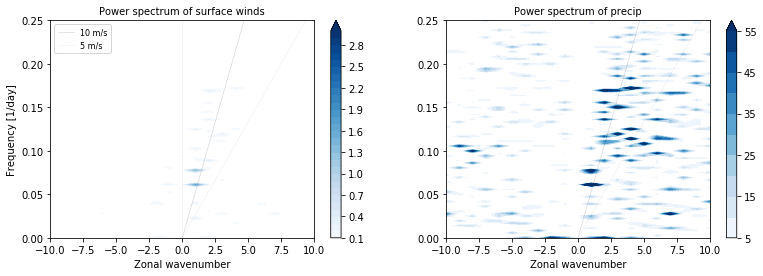

In [499]:
figsize(13,4)
subplot(121)
contourf(-n[:],freq[lm:]*86400.,(udiff)*1e-8,arange(0.1,3.1,.1),extend='max',cmap=cm.Blues)
colorbar()
xlabel('Zonal wavenumber')
ylabel('Frequency [1/day]')
title('Power spectrum of surface winds',fontsize=10)
k = n/2575.e3
#k = n/2575.e3/cos(lat[j15S:j15N]*pi/180.).mean()
plot(-n[:],-k*10.*86400./2/pi,'k',alpha=0.2,linewidth=0.5,label='10 m/s')
plot(-n[:],-k*5.*86400./2/pi,'k:',alpha=0.2,linewidth=0.5,label='5 m/s')
plot(-n,n*0.,'k:',alpha=0.25,linewidth=0.5)
plot([0,0],[-1,1],'k:',alpha=0.25,linewidth=0.5)
xlim(-10,10)
ylim(0,0.25)
legend(loc=2,fontsize=8)
subplot(122)
contourf(-n[:],freq[lm:]*86400.,(pdiff),arange(5,60,5),extend='max',cmap=cm.Blues)
colorbar()
xlabel('Zonal wavenumber')
title('Power spectrum of precip',fontsize=10)
plot(-n[:],-k*10.*86400./2/pi,'k',alpha=0.2,linewidth=0.5,label='10 m/s')
plot(-n[:],-k*5.*86400./2/pi,'k:',alpha=0.2,linewidth=0.5,label='5 m/s')
xlim(-10,10)
ylim(0,0.25)

Kind of a mess, but there seems to be a Kelvin wave signal approximately 5-10 m/s.  There's variability elsewhere, but it's impossible to identify what.  I can take a closer look by analyzing the symmetric and antisymmetric components separately.  

Question:  Is it better to define the asymmetric component as the difference of the total u variable minus the symmetric component, or half the difference of the hemispheric components?  If we add the latter with the symmetric compponent:

$U_{sym} = {uN+uS \over 2}$

$U_{asm} = {uN-uS \over 2}$

$U_{sym}+U_{asym} = uN$

which is the total u of the northern hemisphere.  If the former:

$U_{asm} = u-{U_{sym} \over 2}$

$U_{sym}+U_{asym} = u+U_{asym}/2$

The former is the right definition.  There's no point in concatentating the hemispheres because the information is redundant between hemispheres.


In [500]:
usym = 0.5*(dat['ucomp'][:,km,nj/2-1::-1].values+dat['ucomp'][:,km,nj/2:].values)
uasym = 0.5*(dat['ucomp'][:,km,nj/2-1::-1].values-dat['ucomp'][:,km,nj/2:].values)
vsym = 0.5*(dat['vcomp'][:,km,nj/2-1::-1].values+dat['vcomp'][:,km,nj/2:].values)
vasym = 0.5*(dat['vcomp'][:,km,nj/2-1::-1].values-dat['vcomp'][:,km,nj/2:].values)
latN = lat[nj/2:].values
j15Nhemi = argmin(abs(latN-15.))+1
print shape(usym),shape(uasym),len(latN),latN[j15Nhemi],j15Nhemi

(360, 16, 64) (360, 16, 64) 16 19.3822313464 3


Text(0.5,1,u'asymmetric component, 2.8deg lat')

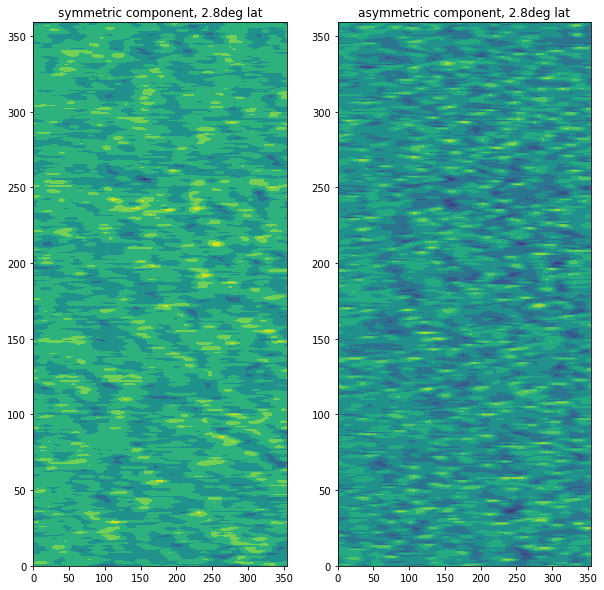

In [501]:
figsize(10,10)
subplot(121)
contourf(lon,arange(360),vsym[:,0])
title('symmetric component, %3.1fdeg lat' %latN[0])
subplot(122)
contourf(lon,arange(360),vasym[:,0])
title('asymmetric component, %3.1fdeg lat' %latN[0])

*Note to return to xarray for symmetrizing so as to carry forward xarray functionality (e.g. "mean" below)*

In [502]:
usymtrop = average(usym[:,:j15Nhemi],axis=1,weights=cos(latN[:j15Nhemi]*pi/180.))
uasymtrop = average(uasym[:,:j15Nhemi],axis=1,weights=cos(latN[:j15Nhemi]*pi/180.))
vsymtrop = average(vsym[:,:j15Nhemi],axis=1,weights=cos(latN[:j15Nhemi]*pi/180.))
vasymtrop = average(vasym[:,:j15Nhemi],axis=1,weights=cos(latN[:j15Nhemi]*pi/180.))

Text(0.5,1,u'asymmetric component, -13.8--13.8 lat')

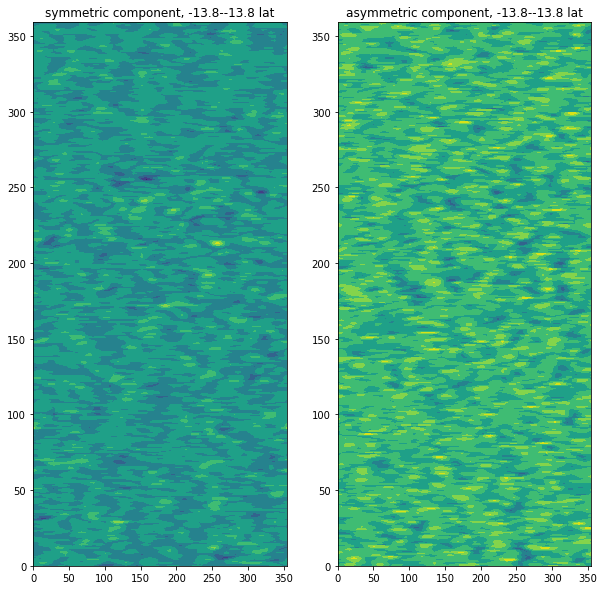

In [503]:
subplot(121)
contourf(lon,arange(360),vsymtrop)
title('symmetric component, %3.1f--%3.1f lat' %(lat[j15S].values,lat[j15N-1].values))
subplot(122)
contourf(lon,arange(360),vasymtrop)
title('asymmetric component, %3.1f--%3.1f lat' %(lat[j15S].values,lat[j15N-1].values))

In [504]:
# Compute antisymmetric and symmetric power spectra
## DEFS
# win = index length of FFT window
# lmax = number of windows in selected data
a    = 6378.e3
y = a*lat*pi/180.
#win = 4*50  # 50 days
win = nl    # entire range  
lmax = nl/win

dt = 86400.

# fft
nfreq= win
n    = fftfreq(ni,d=1./ni)
freq = fftfreq(nfreq,d=dt)
usymfft1 = zeros((lmax,win,ni),'d')
uasymfft1 = zeros((lmax,win,ni),'d')
vsymfft1 = zeros((lmax,win,ni),'d')
vasymfft1 = zeros((lmax,win,ni),'d')
prfft1 = zeros((lmax,win,ni),'d')
usympr_usympr = zeros((lmax,win,ni),'d')
uasympr_uasympr = zeros((lmax,win,ni),'d')
vsympr_usympr = zeros((lmax,win,ni),'d')
vasympr_uasympr = zeros((lmax,win,ni),'d')
prpr_prpr = zeros((lmax,win,ni),'d')
uave_sm = zeros((lmax),'d')
uave_nosm = zeros((lmax),'d')
for l in range(lmax):
    usymfft = fft2(usymtrop[l*win:(l+1)*win],axes=(0,-1))
    usymfft1[l] = usymfft
    uasymfft = fft2(uasymtrop[l*win:(l+1)*win],axes=(0,-1))
    uasymfft1[l] = uasymfft
    vsymfft = fft2(vsymtrop[l*win:(l+1)*win],axes=(0,-1))
    vsymfft1[l] = vsymfft
    vasymfft = fft2(vasymtrop[l*win:(l+1)*win],axes=(0,-1))
    vasymfft1[l] = vasymfft
    # power spectra
    usympr_usympr[l] = 2.*real(usymfft*conj(usymfft))+2.*real(vsymfft*conj(vsymfft))
    uasympr_uasympr[l] = 2.*real(uasymfft*conj(uasymfft))+2.*real(vasymfft*conj(vasymfft))

nunsort = n.copy()
funsort = freq.copy()
nsort = argsort(n)
fsort = argsort(freq)
n = n[nsort]
freq = freq[fsort]
# Sort for plotting purposes
for l in range(lmax):
    for ll in range(nfreq):
        usympr_usympr[l,ll,:] = usympr_usympr[l,ll,nsort]
        uasympr_uasympr[l,ll,:] = uasympr_uasympr[l,ll,nsort]
    for i in range(len(n)):
        usympr_usympr[l,:,i] = usympr_usympr[l,fsort,i]
        uasympr_uasympr[l,:,i] = uasympr_uasympr[l,fsort,i]


/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


In [505]:
# Smooth the spectrum and subtract from itself to remove background

times = 10 # number of sweeps with gaussian filter of width 4 per day
lm = argmin(abs(freq))
day = 0
dfreq = abs(freq[0]-freq[1])
period = 1/freq/86400.
var = usympr_usympr[day,lm:,:].copy()
for num in range(times):
    for l in range(len(freq[lm:])):
        var[l,:] = average(var, \
                    weights=exp(-((freq[lm:]-freq[lm+l])/dfreq)**2.), \
                    axis=0)
usymdiff = usympr_usympr[day,lm:,:]-var
#usymdiff = var
var = uasympr_uasympr[day,lm:,:].copy()
for num in range(times):
    for l in range(len(freq[lm:])):
        var[l,:] = average(var, \
                    weights=exp(-((freq[lm:]-freq[lm+l])/dfreq)**2.), \
                    axis=0)
uasymdiff = uasympr_uasympr[day,lm:,:]-var
#uasymdiff = var


/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


180 3.21502057613e-08


/home/mitch/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 180)

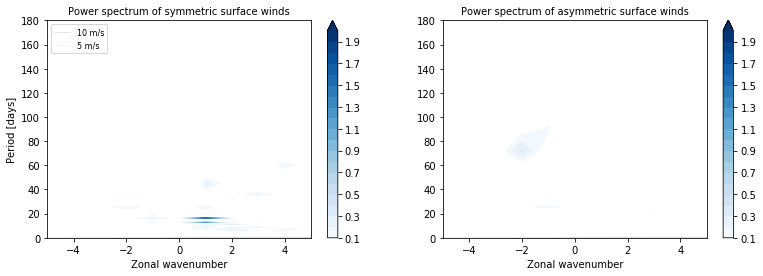

In [507]:
figsize(13,4)
print lm,freq[lm+1]
period = 1./freq[lm:]/86400.
period[0] = period[1]
subplot(121)
contourf(-n[:],period,(usymdiff)*1e-8,arange(0.1,2.1,.1),extend='max',cmap=cm.Blues)
#contourf(-n[:],freq[lm:]*86400.,(usymdiff)*1e-8,arange(0.1,20.1,.1),extend='max',cmap=cm.Blues)
colorbar()
xlabel('Zonal wavenumber')
ylabel('Period [days]')
#ylabel('Frequency [1/day]')
title('Power spectrum of symmetric surface winds',fontsize=10)
k = n/2575.e3
plot(-n[:],-k*10.*86400./2/pi,'k',alpha=0.2,linewidth=0.5,label='10 m/s')
plot(-n[:],-k*5.*86400./2/pi,'k:',alpha=0.2,linewidth=0.5,label='5 m/s')
plot(-n,n*0.,'k:',alpha=0.25,linewidth=0.5)
plot([0,0],[-1,1],'k:',alpha=0.25,linewidth=0.5)
xlim(-5,5)
ylim(0,180)
#ylim(0,0.2)
legend(loc=2,fontsize=8)
subplot(122)
contourf(-n[:],period,(uasymdiff)*1e-8,arange(0.1,2.1,.1),extend='max',cmap=cm.Blues)
#contourf(-n[:],freq[lm:]*86400.,(uasymdiff)*1e-8,arange(0.1,2.1,.1),extend='max',cmap=cm.Blues)
colorbar()
xlabel('Zonal wavenumber')
title('Power spectrum of asymmetric surface winds',fontsize=10)
plot(-n[:],-k*10.*86400./2/pi,'k',alpha=0.2,linewidth=0.5,label='10 m/s')
plot(-n[:],-k*5.*86400./2/pi,'k:',alpha=0.2,linewidth=0.5,label='5 m/s')
plot(-n,n*0.,'k:',alpha=0.25,linewidth=0.5)
plot([0,0],[-1,1],'k:',alpha=0.25,linewidth=0.5)
xlim(-5,5)
ylim(0,180)
#ylim(0,0.2)